`라이브러리 설치`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.spatial import distance
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

plt.rcParams['font.family'] = 'Gmarket Sans'
plt.rcParams['axes.unicode_minus'] = False

import sys
sys.path.append('/Users/jun-seokoh/Desktop/TIL/data analysis')

from da_utils import profile, outliers, pattern

`파일 읽어오기(apt 2020 ~ 2024)`

In [50]:
df_2024 = pd.read_csv('./apt_2024.csv', encoding='EUC KR')

df_2023 = pd.read_csv('./apt_2023.csv', encoding='EUC KR')
df_2022 = pd.read_csv('./apt_2022.csv', encoding='EUC KR')
df_2021 = pd.read_csv('./apt_2021.csv', encoding='EUC KR')
df_2020 = pd.read_csv('./apt_2020.csv', encoding='EUC KR')
interest_rate = pd.read_csv('./interest.csv', encoding='UTF-8')
display(interest_rate)
df_2024.info()


,변경년도,변경월일,기준금리
0,2024,11월 28일,3.00
1,2024,10월 11일,3.25
2,2023,01월 13일,3.50
3,2022,11월 24일,3.25
4,2022,10월 12일,3.00
5,2022,08월 25일,2.50
6,2022,07월 13일,2.25
7,2022,05월 26일,1.75
8,2022,04월 14일,1.50
9,2022,01월 14일,1.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NO        57458 non-null  int64  
 1   시군구       57458 non-null  object 
 2   번지        57458 non-null  object 
 3   본번        57458 non-null  int64  
 4   부번        57458 non-null  int64  
 5   단지명       57458 non-null  object 
 6   전용면적(㎡)   57458 non-null  float64
 7   계약년월      57458 non-null  int64  
 8   계약일       57458 non-null  int64  
 9   거래금액(만원)  57458 non-null  object 
 10  동         57458 non-null  object 
 11  층         57458 non-null  int64  
 12  매수자       57458 non-null  object 
 13  매도자       57458 non-null  object 
 14  건축년도      57458 non-null  int64  
 15  도로명       57458 non-null  object 
 16  해제사유발생일   57458 non-null  object 
 17  거래유형      57458 non-null  object 
 18  중개사소재지    57458 non-null  object 
 19  등기일자      57458 non-null  object 
dtypes: float64(1), int64(7), obj

`전처리 함수 생성`

In [3]:

def clean_data(df):
    # df 복사
    dfc = df.copy()
    
    # 결측치 '-' -> Na
    obj_cols = dfc.select_dtypes(include=['object']).columns
    dfc[obj_cols] = dfc[obj_cols].replace('-', pd.NA)
    
    # 1) 중복 제거
    dfc.drop_duplicates(subset=['단지명', '계약년월', '계약일','전용면적(㎡)','층','거래금액(만원)'], inplace=True)

    # 2) 해제 건 분리 보관 → df_cancel, 본데이터에서 제거
    if '해제사유발생일' in dfc.columns:
        df_cancel = dfc[dfc['해제사유발생일'].notna()].copy()
        dfc = dfc[dfc['해제사유발생일'].isna()].copy()
    else:
        df_cancel = pd.DataFrame(columns=dfc.columns)

    # 3) 계약년월+계약일 → 계약일자(datetime), 계약일 드롭
    ym = pd.to_datetime(dfc['계약년월'].astype(str), format='%Y%m', errors='coerce')
    day = dfc['계약일'].astype('Int64')
    dfc['계약일자'] = ym + pd.to_timedelta(day - 1, unit='D')
    dfc.drop(columns=['계약일'], inplace=True)

    # 4) 시군구 → 시/구/동 분해 후 원본 드롭
    ext = dfc['시군구'].str.extract(r'^(?P<시>\S+)\s+(?P<구>\S+)\s*(?P<동>.*)$')
    dfc[['시','구','동']] = ext[['시','구','동']]
    dfc.drop(columns=['시군구'], inplace=True)

    # 5) 거래금액(만원) → int
    dfc['거래금액(만원)'] = (
        dfc['거래금액(만원)'].astype(str)
        .str.replace(',', '', regex=False)
        # .str.replace('\u00a0', '', regex=False)
        # .str.strip()
        # .replace({'': pd.NA})
        .astype('Int64')
    )
    
    # 6) 파생: 평단가(만원) (면적 대비 비교 지표)
    dfc['평단가(만원)'] = (dfc['거래금액(만원)'].astype(float) / (dfc['전용면적(㎡)'] / 3.3)).round(2)
    
    # 7) 불필요 컬럼 드롭 (필요시 수정)
    drop_cols = ['NO','번지','본번','부번','도로명','거래유형','중개사소재지','등기일자','매수자','매도자','해제사유발생일']
    dfc.drop(columns=[c for c in drop_cols if c in dfc.columns], inplace=True, errors='ignore')

    # 8) 컬럼 정리: 최소 분석셋 우선 배치
    preferred = ['계약일자','시','구','동','전용면적(㎡)','층','건축년도','거래금액(만원)','평당가(만원)','단지명',]
    exist = [c for c in preferred if c in dfc.columns]
    others = [c for c in dfc.columns if c not in exist]
    dfc = dfc[exist + others].reset_index(drop=True)
    
    
    return dfc, df_cancel


`전처리 데이터 저장`

In [4]:
df_2024_c, df_2024_canceled  = clean_data(df_2024)
df_2023_c, df_2023_canceled  = clean_data(df_2023)
df_2022_c, df_2022_canceled  = clean_data(df_2022)
df_2021_c, df_2021_canceled  = clean_data(df_2021)
df_2020_c, df_2020_canceled  = clean_data(df_2020)
df_2020_c.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79636 entries, 0 to 79635
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   계약일자      79636 non-null  datetime64[ns]
 1   시         79636 non-null  object        
 2   구         79636 non-null  object        
 3   동         79636 non-null  object        
 4   전용면적(㎡)   79636 non-null  float64       
 5   층         79636 non-null  int64         
 6   건축년도      79636 non-null  int64         
 7   거래금액(만원)  79636 non-null  Int64         
 8   단지명       79636 non-null  object        
 9   계약년월      79636 non-null  int64         
 10  평단가(만원)   79636 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 6.8+ MB


`결측값 검증`

In [5]:
profile.get_data_profile(df_2024_c) # 결측값 없음
profile.get_data_profile(df_2023_c) # 결측값 없음
profile.get_data_profile(df_2022_c) # 결측값 없음
profile.get_data_profile(df_2021_c) # 결측값 없음
profile.get_data_profile(df_2020_c) # 결측값 없음

# pattern.analyze_missing_patterns(df_2024_c)

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 53747행 x 11열
- 메모리 사용량: 19.29mb
- 수치형 변수: 6개
- 범주형 변수: 4개

2. 결측값 분석
결측값 없음. 완전

3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,전용면적(㎡),76.615,28.639,11.48,273.96,1.192,3.859,8.460,11.963
1,층,9.899,6.571,-2.00,68.00,1.187,2.845,1.626,0.119
2,건축년도,2003.368,11.215,1965.00,2024.00,-0.167,-0.597,0.074,0.112
3,거래금액(만원),120363.947,90870.319,7000.00,2500000.00,3.680,35.359,6.410,5.433
4,계약년월,202406.545,2.908,202401.00,202412.00,0.024,-0.679,0.000,0.022
5,평단가(만원),5054.003,2619.466,739.50,30115.82,1.698,4.000,5.143,68.774



4. 분포 이상 감지

- 극심한 왜도(|skewness| > 2)
--거래금액(만원): 왜도 =  3.680000

- 높은 이상값 비율(>5%)
['전용면적(㎡)', '거래금액(만원)', '평단가(만원)']
--전용면적(㎡): 이상값 = 8.5%
--거래금액(만원): 이상값 = 6.4%
--평단가(만원): 이상값 = 5.1%
종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 33191행 x 11열
- 메모리 사용량: 11.91mb
- 수치형 변수: 6개
- 범주형 변수: 4개

2. 결측값 분석
결측값 없음. 완전

3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,전용면적(㎡),74.766,29.830,10.78,309.70,1.184,3.962,9.319,15.799
1,층,9.921,6.557,-3.00,65.00,1.103,2.148,1.573,0.178
2,건축년도,2003.392,11.360,1961.00,2023.00,-0.214,-0.618,0.108,0.175
3,거래금액(만원),106980.723,76978.305,7400.00,1800000.00,3.087,21.999,5.962,7.098
4,계약년월,202306.457,3.009,202301.00,202312.00,0.030,-0.920,0.000,0.036
5,평단가(만원),4621.854,2216.362,683.04,22108.91,1.486,2.745,5.010,72.631



4. 분포 이상 감지

- 극심한 왜도(|skewness| > 2)
--거래금액(만원): 왜도 =  3.087000

- 높은 이상값 비율(>5%)
['전용면적(㎡)', '거래금액(만원)', '평단가(만원)']
--전용면적(㎡): 이상값 = 9.3%
--거래금액(만원): 이상값 = 6.0%
--평단가(만원): 이상값 = 5.0%
종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 11440행 x 11열
- 메모리 사용량: 4.09mb
- 수치형 변수: 6개
- 범주형 변수: 4개

2. 결측값 분석
결측값 없음. 완전

3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,전용면적(㎡),67.465,37.730,11.33,301.47,1.141,2.939,3.470,32.002
1,층,9.333,6.336,-1.00,64.00,1.449,4.322,2.028,0.472
2,건축년도,2004.080,11.598,1961.00,2022.00,-0.483,-0.220,0.577,0.498
3,거래금액(만원),98293.208,93940.552,6700.00,1450000.00,3.378,21.373,6.722,14.187
4,계약년월,202205.631,3.250,202201.00,202212.00,0.504,-0.785,0.000,0.105
5,평단가(만원),4496.957,2364.330,748.38,18412.74,1.829,4.386,6.049,85.446



4. 분포 이상 감지

- 극심한 왜도(|skewness| > 2)
--거래금액(만원): 왜도 =  3.378000

- 높은 이상값 비율(>5%)
['거래금액(만원)', '평단가(만원)']
--거래금액(만원): 이상값 = 6.7%
--평단가(만원): 이상값 = 6.0%
종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 41307행 x 11열
- 메모리 사용량: 14.75mb
- 수치형 변수: 6개
- 범주형 변수: 4개

2. 결측값 분석
결측값 없음. 완전

3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,전용면적(㎡),73.457,32.654,10.156,317.36,1.285,4.211,10.466,15.857
1,층,9.146,6.237,-1.000,66.00,1.372,4.309,1.331,0.155
2,건축년도,2001.725,10.298,1961.000,2022.00,-0.184,-0.206,0.547,0.140
3,거래금액(만원),102361.102,74186.790,6600.000,1200000.00,2.822,16.347,5.718,6.135
4,계약년월,202105.427,3.085,202101.000,202112.00,0.214,-0.919,0.000,0.029
5,평단가(만원),4530.755,2172.979,583.380,17480.87,1.686,4.070,5.067,74.421



4. 분포 이상 감지

- 극심한 왜도(|skewness| > 2)
--거래금액(만원): 왜도 =  2.822000

- 높은 이상값 비율(>5%)
['전용면적(㎡)', '거래금액(만원)', '평단가(만원)']
--전용면적(㎡): 이상값 = 10.5%
--거래금액(만원): 이상값 = 5.7%
--평단가(만원): 이상값 = 5.1%
종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 79636행 x 11열
- 메모리 사용량: 28.44mb
- 수치형 변수: 6개
- 범주형 변수: 4개

2. 결측값 분석
결측값 없음. 완전

3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,전용면적(㎡),76.325,29.489,11.48,317.36,1.193,3.614,8.195,9.813
1,층,9.032,6.071,-3.00,67.00,1.170,2.826,1.136,0.078
2,건축년도,2000.442,9.577,1961.00,2021.00,-0.159,-0.158,0.628,0.073
3,거래금액(만원),84788.735,56319.749,6000.00,775000.00,2.358,10.009,5.732,3.458
4,계약년월,202006.421,3.334,202001.00,202012.00,0.057,-0.952,0.000,0.015
5,평단가(만원),3659.954,1790.156,510.71,18054.62,1.586,3.466,4.856,65.055



4. 분포 이상 감지

- 극심한 왜도(|skewness| > 2)
--거래금액(만원): 왜도 =  2.358000

- 높은 이상값 비율(>5%)
['전용면적(㎡)', '거래금액(만원)']
--전용면적(㎡): 이상값 = 8.2%
--거래금액(만원): 이상값 = 5.7%


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,전용면적(㎡),76.325,29.489,11.48,317.36,1.193,3.614,8.195,9.813
1,층,9.032,6.071,-3.00,67.00,1.170,2.826,1.136,0.078
2,건축년도,2000.442,9.577,1961.00,2021.00,-0.159,-0.158,0.628,0.073
3,거래금액(만원),84788.735,56319.749,6000.00,775000.00,2.358,10.009,5.732,3.458
4,계약년월,202006.421,3.334,202001.00,202012.00,0.057,-0.952,0.000,0.015
5,평단가(만원),3659.954,1790.156,510.71,18054.62,1.586,3.466,4.856,65.055


In [6]:
_, final_ol_2024 = outliers.outlier_detection(df_2024_c)
_, final_ol_2023 = outliers.outlier_detection(df_2023_c)
_, final_ol_2022 = outliers.outlier_detection(df_2022_c)
_, final_ol_2021 = outliers.outlier_detection(df_2021_c)
_, final_ol_2020 = outliers.outlier_detection(df_2020_c)
# ourlier가 특정 지역이나 가격에 분포돼있는 거면 이상치가 아닌, 현상적인 것으로 판단...?(이렇게 써도 되나)

=== 종합 이상값 탐지 시스템 ===
1. 일변량 이상값 탐지 (IQR 방법)
  전용면적(㎡): 4547개 (8.5%)
  층: 874개 (1.6%)
  건축년도: 40개 (0.1%)
  거래금액(만원): 3445개 (6.4%)
  평단가(만원): 2764개 (5.1%)

2. 다변량 이상값 탐지 (마할라노비스 거리)
 임계값(거리): 4.74
 다변량 이상값: 1200개 (2.2%)

3. 다변량 이상값 탐지(Isolation Forest)
  Isolation Forest 이상값: 5375개 (10.0%)

 == 최종 이상값: 4574개 (8.5%)
=== 종합 이상값 탐지 시스템 ===
1. 일변량 이상값 탐지 (IQR 방법)
  전용면적(㎡): 3093개 (9.3%)
  층: 522개 (1.6%)
  건축년도: 36개 (0.1%)
  거래금액(만원): 1979개 (6.0%)
  평단가(만원): 1663개 (5.0%)

2. 다변량 이상값 탐지 (마할라노비스 거리)
 임계값(거리): 4.74
 다변량 이상값: 702개 (2.1%)

3. 다변량 이상값 탐지(Isolation Forest)
  Isolation Forest 이상값: 3319개 (10.0%)

 == 최종 이상값: 2846개 (8.6%)
=== 종합 이상값 탐지 시스템 ===
1. 일변량 이상값 탐지 (IQR 방법)
  전용면적(㎡): 397개 (3.5%)
  층: 232개 (2.0%)
  건축년도: 66개 (0.6%)
  거래금액(만원): 769개 (6.7%)
  평단가(만원): 692개 (6.0%)

2. 다변량 이상값 탐지 (마할라노비스 거리)
 임계값(거리): 4.74
 다변량 이상값: 297개 (2.6%)

3. 다변량 이상값 탐지(Isolation Forest)
  Isolation Forest 이상값: 1144개 (10.0%)

 == 최종 이상값: 1005개 (8.8%)
=== 종합 이상값 탐지 시스템 ===
1. 일변량 이상값 탐지 (IQR 방법)
  전용면적(㎡): 4

### 전체 이상치의 구단위 분포

In [8]:
# 1) 연도별 DataFrame과 outlier mask 매핑
dfs_masks = {
    2024: (df_2024_c, final_ol_2024),
    2023: (df_2023_c, final_ol_2023),
    2022: (df_2022_c, final_ol_2022),
    2021: (df_2021_c, final_ol_2021),
    2020: (df_2020_c, final_ol_2020),
}

frames = []
for year, (df_year, mask) in dfs_masks.items():
    tmp = df_year.copy()
    tmp['is_outlier'] = mask
    # 해당 연도의 전체 이상치 건수
    total_out = tmp['is_outlier'].sum()
    # 구별 이상치 비율(전체 이상치 대비)
    dist = (
        tmp[tmp['is_outlier']]
        .groupby('구')['is_outlier']
        .count()
        .div(total_out)
        .mul(100)
        .reset_index(name='outlier_dist_pct')
    )
    dist['year'] = year
    frames.append(dist)

# 2) 종합
outlier_dist = pd.concat(frames, ignore_index=True)

# 3) 피벗 테이블 (구별 × 연도별 분포 %)
pivot_dist = outlier_dist.pivot(index='구', columns='year', values='outlier_dist_pct').fillna(0).round(1)

print(pivot_dist)

year  2020  2021  2022  2023  2024
구                                 
강남구   27.3  25.5  33.5  28.3  27.9
강동구    4.5   3.1   1.6   1.5   1.6
강북구    0.3   0.1   0.0   0.5   0.2
강서구    0.8   0.6   0.2   1.0   0.5
관악구    1.1   0.6   0.2   0.7   0.5
광진구    1.8   1.5   2.1   2.2   2.1
구로구    1.8   1.8   0.6   1.9   1.1
금천구    0.8   1.4   0.4   0.5   0.5
노원구    0.5   0.3   0.0   0.5   0.6
도봉구    0.6   0.4   0.3   0.6   0.3
동대문구   1.1   1.3   0.1   1.3   2.0
동작구    1.2   3.6   0.5   1.2   1.3
마포구    2.0   1.5   1.7   1.4   1.3
서대문구   1.3   0.8   0.6   1.2   1.7
서초구   18.6  23.6  25.1  21.0  26.4
성동구    2.2   2.6   2.8   2.2   2.4
성북구    1.4   1.2   1.3   1.7   0.9
송파구   14.0  11.7  13.7  14.0  12.1
양천구    3.5   2.2   1.5   3.1   2.3
영등포구   4.2   5.1   3.3   5.0   5.1
용산구    6.2   7.5   8.1   5.4   5.8
은평구    1.1   0.8   0.0   1.1   0.8
종로구    1.2   0.9   0.4   0.9   0.7
중구     1.5   1.2   1.6   1.7   1.2
중랑구    1.0   0.6   0.5   1.2   0.6


`테이블 합치기`

In [9]:
# 전처리 완료된 연도별 테이블들
dfs = [df_2020_c, df_2021_c, df_2022_c, df_2023_c, df_2024_c]

# 하나로 합치기
df_all = pd.concat(dfs, ignore_index=True)

# 연도 컬럼 추가
df_all['연도'] = df_all['계약일자'].dt.year

df_all

,계약일자,시,구,동,전용면적(㎡),층,건축년도,거래금액(만원),단지명,계약년월,평단가(만원),연도
0,2020-12-31,서울특별시,성북구,돈암동,84.980,2,2013,82000,돈암동해피트리,202012,3184.28,2020
1,2020-12-31,서울특별시,용산구,한남동,240.305,2,2011,710000,한남더힐,202012,9750.11,2020
2,2020-12-31,서울특별시,성동구,금호동4가,84.880,4,2018,180000,힐스테이트서울숲리버,202012,6998.11,2020
3,2020-12-31,서울특별시,동대문구,제기동,104.220,8,1978,59500,공성,202012,1884.00,2020
4,2020-12-31,서울특별시,용산구,도원동,84.920,10,2001,135000,삼성래미안,202012,5246.11,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
219316,2024-01-01,서울특별시,강동구,상일동,59.980,10,2020,117500,고덕아르테온,202401,6464.65,2024
219317,2024-01-01,서울특별시,송파구,가락동,84.885,5,2007,149000,래미안파크팰리스,202401,5792.54,2024
219318,2024-01-01,서울특별시,송파구,가락동,59.940,11,2005,100000,"가락3차쌍용스윗닷홈101동,102동",202401,5505.51,2024
219319,2024-01-01,서울특별시,구로구,개봉동,84.960,11,2000,58000,한진,202401,2252.82,2024


=== 종합 이상값 탐지 시스템 ===
1. 일변량 이상값 탐지 (IQR 방법)
  전용면적(㎡): 520개 (4.5%)
  층: 92개 (0.8%)
  건축년도: 239개 (2.1%)
  거래금액(만원): 341개 (3.0%)
  평단가(만원): 114개 (1.0%)

2. 다변량 이상값 탐지 (마할라노비스 거리)
 임계값(거리): 4.93
 다변량 이상값: 313개 (2.7%)

3. 다변량 이상값 탐지(Isolation Forest)
  Isolation Forest 이상값: 1151개 (10.0%)

 == 최종 이상값: 928개 (8.1%)
=== 종합 이상값 탐지 시스템 ===
1. 일변량 이상값 탐지 (IQR 방법)
  전용면적(㎡): 132개 (3.2%)
  층: 93개 (2.3%)
  건축년도: 596개 (14.6%)
  거래금액(만원): 292개 (7.2%)
  평단가(만원): 136개 (3.3%)

2. 다변량 이상값 탐지 (마할라노비스 거리)
 임계값(거리): 4.93
 다변량 이상값: 86개 (2.1%)

3. 다변량 이상값 탐지(Isolation Forest)
  Isolation Forest 이상값: 407개 (10.0%)

 == 최종 이상값: 354개 (8.7%)
=== 종합 이상값 탐지 시스템 ===
1. 일변량 이상값 탐지 (IQR 방법)
  전용면적(㎡): 474개 (5.4%)
  층: 117개 (1.3%)
  건축년도: 31개 (0.4%)
  거래금액(만원): 345개 (3.9%)
  평단가(만원): 180개 (2.1%)

2. 다변량 이상값 탐지 (마할라노비스 거리)
 임계값(거리): 4.93
 다변량 이상값: 210개 (2.4%)

3. 다변량 이상값 탐지(Isolation Forest)
  Isolation Forest 이상값: 878개 (10.0%)

 == 최종 이상값: 606개 (6.9%)
=== 종합 이상값 탐지 시스템 ===
1. 일변량 이상값 탐지 (IQR 방법)
  전용면적(㎡): 820개 (9.3%)
 

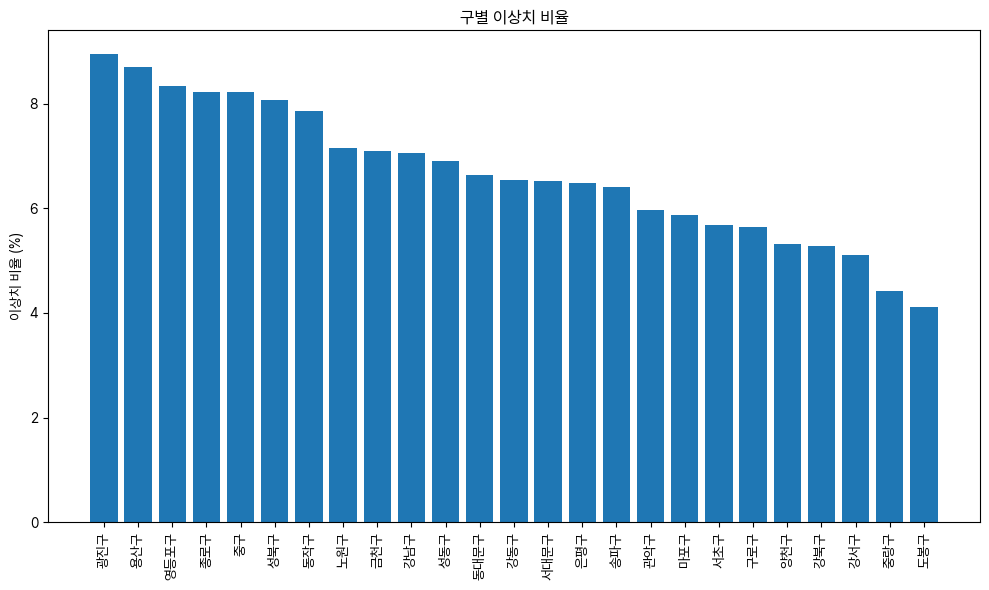

In [10]:
# 1) 구별 이상치 분포 계산
results = []
for gu in df_all['구'].unique():
    df_sub = df_all[df_all['구'] == gu].reset_index(drop=True)
    _, mask = outliers.outlier_detection(df_sub,
                                         chi_q=0.999,
                                         iso_cont=0.1,
                                         final_threshold=2)
    n_out = mask.sum()
    n_tot = len(mask)
    pct   = n_out / n_tot * 100
    results.append({'구': gu, '이상치비율': pct})

outlier_by_district = pd.DataFrame(results).sort_values('이상치비율', ascending=False)

# 2) 시각화: 구별 이상치 비율 바 차트
plt.figure(figsize=(10, 6))
plt.bar(outlier_by_district['구'], outlier_by_district['이상치비율'])
plt.xticks(rotation=90)
plt.ylabel('이상치 비율 (%)')
plt.title('구별 이상치 비율')
plt.tight_layout()
plt.show()

### 구 단위 이상치 제거 함수

In [17]:
import contextlib, io

def remove_outliers_by_district(df: pd.DataFrame,
                                chi_q=0.999,
                                iso_cont=0.1,
                                final_threshold=2
                               ) -> pd.DataFrame:
    """
    연도별로 분리된 DataFrame(df_202X_c 등)에 대해
    구 단위로 outliers.outlier_detection을 적용하여
    이상치 행을 제거한 뒤, 같은 연도의 깨끗한 데이터프레임을 반환합니다.
    """
    cleaned = []
    for gu in df['구'].unique():
        sub = df[df['구'] == gu].reset_index(drop=True)
        # outlier_detection 출력 억제
        buf = io.StringIO()
        with contextlib.redirect_stdout(buf):
            _, mask = outliers.outlier_detection(
                sub,
                chi_q=chi_q,
                iso_cont=iso_cont,
                final_threshold=final_threshold
            )
        # mask=True인 이상치 제거
        cleaned.append(sub[~mask])
    # 같은 연도의 모든 구 결합
    return pd.concat(cleaned, ignore_index=True)



### 이상치 처리한 df_all 다시 만들기

In [18]:
# 이상치 처리
df_2024_c = remove_outliers_by_district(df_2024_c)
df_2023_c = remove_outliers_by_district(df_2023_c)
df_2022_c = remove_outliers_by_district(df_2022_c)
df_2021_c = remove_outliers_by_district(df_2021_c)
df_2020_c = remove_outliers_by_district(df_2020_c)

# 전처리 완료된 연도별 테이블들
dfs = [df_2020_c, df_2021_c, df_2022_c, df_2023_c, df_2024_c]

# 하나로 합치기
df_all = pd.concat(dfs, ignore_index=True)

# 연도 컬럼 추가
df_all['연도'] = df_all['계약일자'].dt.year

df_all

,계약일자,시,구,동,전용면적(㎡),층,건축년도,거래금액(만원),단지명,계약년월,평단가(만원),연도
0,2020-12-31,서울특별시,성북구,돈암동,84.980,2,2013,82000,돈암동해피트리,202012,3184.28,2020
1,2020-12-31,서울특별시,성북구,길음동,59.990,8,2003,85000,길음뉴타운1단지(래미안길음1차),202012,4675.78,2020
2,2020-12-31,서울특별시,성북구,정릉동,59.980,2,2001,47000,대우,202012,2585.86,2020
3,2020-12-31,서울특별시,성북구,정릉동,84.920,12,1999,54000,우방,202012,2098.45,2020
4,2020-12-31,서울특별시,성북구,종암동,84.980,7,2008,80000,우림카이저팰리스,202012,3106.61,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
195834,2024-01-08,서울특별시,강북구,미아동,84.705,4,2003,60000,삼각산아이원,202401,2337.52,2024
195835,2024-01-06,서울특별시,강북구,미아동,59.990,17,2011,64400,두산위브트레지움,202401,3542.59,2024
195836,2024-01-06,서울특별시,강북구,미아동,59.820,11,2011,65000,두산위브트레지움,202401,3585.76,2024
195837,2024-01-03,서울특별시,강북구,미아동,84.970,14,2011,78500,두산위브트레지움,202401,3048.72,2024


평단가 기준 상위 지역 선별
> 평단가 기준 상위 66%를 꾸준히 들어온 지역 선발
- 강남
- 서초
- 용산
- 송파
- 성동
- 마포

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_45014/1283907779.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly = yearly.groupby('연도', group_keys=False).apply(compute_pct)


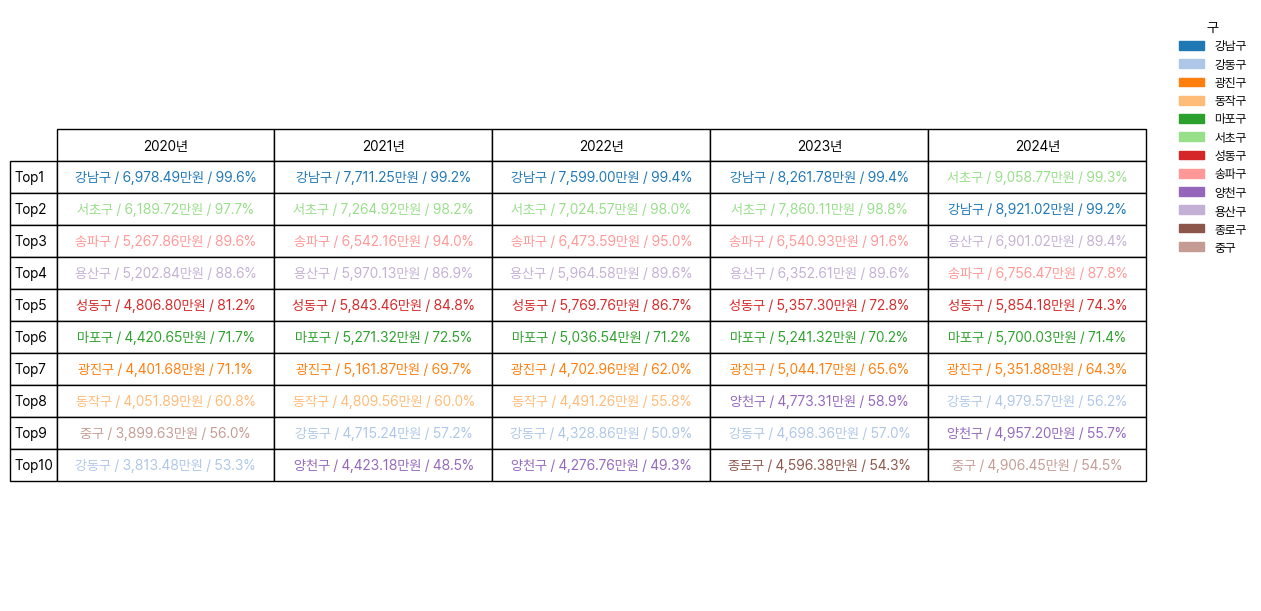

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import norm

# 1) 연도·구별 평균 평단가 계산
yearly = (
    df_all
    .groupby(['연도','구'])['평단가(만원)']
    .mean()
    .reset_index(name='평단가')
)

# 2) 연도별 정규분포 퍼센타일 계산
def compute_pct(df):
    μ, σ = df['평단가'].mean(), df['평단가'].std(ddof=1)
    df['percentile'] = df['평단가'].apply(lambda x: norm.cdf((x-μ)/σ) * 100)
    return df

yearly = yearly.groupby('연도', group_keys=False).apply(compute_pct)

# 3) 연도별 순위 매기기
yearly['순위'] = (
    yearly
    .groupby('연도')['평단가']
    .rank(method='dense', ascending=False)
    .astype(int)
)
# 4) 연도별 Top10 추출
top10 = (
    yearly[yearly['순위'] <= 10]
    .sort_values(['연도','순위'])
    .reset_index(drop=True)
)

# 준비: 연도 리스트과 순위 리스트
years = sorted(top10['연도'].unique())
ranks = list(range(1, 11))

# 1) 구별 색상 매핑 (tab20)
districts = sorted(top10['구'].unique())
cmap = plt.get_cmap('tab20')
color_map = {g: cmap(i % cmap.N) for i, g in enumerate(districts)}

# 2) 매트릭스 형태로 텍스트 및 구 리스트 생성
cell_text = []
district_grid = []
for rank in ranks:
    text_row = []
    dist_row = []
    for yr in years:
        entry = top10[(top10['연도'] == yr) & (top10['순위'] == rank)].iloc[0]
        gu    = entry['구']
        price = entry['평단가']
        pct   = entry['percentile']
        text  = f"{gu} / {price:,.2f}만원 / {pct:.1f}%"
        text_row.append(text)
        dist_row.append(gu)
    cell_text.append(text_row)
    district_grid.append(dist_row)

# 3) 테이블 시각화
fig, ax = plt.subplots(figsize=(2.5 * len(years), 6), constrained_layout=True)
ax.axis('off')

legend_items = [mpatches.Patch(color=color_map[g], label=g) for g in districts]
ax.legend(
    handles=legend_items,
    title="구",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=False,
    fontsize=9
)

tbl = ax.table(
    cellText=cell_text,
    rowLabels=[f"Top{r}" for r in ranks],
    colLabels=[f"{yr}년" for yr in years],
    cellLoc='center',
    loc='center'
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# 4) 셀별 텍스트 색상 적용
for i, dist_row in enumerate(district_grid):
    for j, gu in enumerate(dist_row):
        cell = tbl[i+1, j]  # rowLabels occupy row 0
        cell.get_text().set_color(color_map[gu])

plt.show()

### 인기구, 비인기구 구별

In [24]:
# 1) 연도별 퍼센타일 계산(이미 완료된 yearly 사용 가정)
#    yearly에는 ['연도','구','평단가(만원)','percentile','순위']가 있음.

# 2) 전체 연도 수
n_years = yearly['연도'].nunique()

# 3) 상위 66% 조건 충족 연도별 횟수 집계
consistent = (
    yearly
    .assign(is_top66 = yearly['percentile'] >= 66)
    .groupby('구')['is_top66']
    .sum()
)

# 4) 모든 연도에서 상위 66%인 구 선별
popular_gu = consistent[consistent == n_years].index.tolist()

print("꾸준히 상위 66%에 든 인기 지역:", popular_gu)

# popular_gu: 꾸준히 상위 66%인 구 리스트
df_all['인기구'] = df_all['구'].isin(popular_gu)
# True = 인기, False = 비인기

# 필요하면 문자열로 변환
df_all['인기구'] = df_all['인기구'].map({True:'인기', False:'비인기'})
df_all


꾸준히 상위 66%에 든 인기 지역: ['강남구', '마포구', '서초구', '성동구', '송파구', '용산구']


,계약일자,시,구,동,전용면적(㎡),층,건축년도,거래금액(만원),단지명,계약년월,평단가(만원),연도,인기구,년월
0,2020-12-31,서울특별시,성북구,돈암동,84.980,2,2013,82000,돈암동해피트리,202012,3184.28,2020,비인기,2020-12-01
1,2020-12-31,서울특별시,성북구,길음동,59.990,8,2003,85000,길음뉴타운1단지(래미안길음1차),202012,4675.78,2020,비인기,2020-12-01
2,2020-12-31,서울특별시,성북구,정릉동,59.980,2,2001,47000,대우,202012,2585.86,2020,비인기,2020-12-01
3,2020-12-31,서울특별시,성북구,정릉동,84.920,12,1999,54000,우방,202012,2098.45,2020,비인기,2020-12-01
4,2020-12-31,서울특별시,성북구,종암동,84.980,7,2008,80000,우림카이저팰리스,202012,3106.61,2020,비인기,2020-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195834,2024-01-08,서울특별시,강북구,미아동,84.705,4,2003,60000,삼각산아이원,202401,2337.52,2024,비인기,2024-01-01
195835,2024-01-06,서울특별시,강북구,미아동,59.990,17,2011,64400,두산위브트레지움,202401,3542.59,2024,비인기,2024-01-01
195836,2024-01-06,서울특별시,강북구,미아동,59.820,11,2011,65000,두산위브트레지움,202401,3585.76,2024,비인기,2024-01-01
195837,2024-01-03,서울특별시,강북구,미아동,84.970,14,2011,78500,두산위브트레지움,202401,3048.72,2024,비인기,2024-01-01


In [21]:
import numpy as np
import pandas as pd

# 1) 월 키
df_all['년월'] = df_all['계약일자'].dt.to_period('M').dt.to_timestamp()

# 2) 그룹별 월별 평단가 중위값
mp = (
    df_all
    .groupby(['인기구','년월'])['평단가(만원)']
    .median()
    .reset_index()
    .sort_values(['인기구','년월'])
)

# 3) 월수익률 계산
mp['log_price'] = np.log(mp['평단가(만원)'])
mp['월수익률'] = mp.groupby('인기구')['log_price'].diff()

# 4) 그룹별 통계
stats = (
    mp.groupby('인기구')
      .agg(
          평균_월수익률 = ('월수익률','mean'),
          월변동성     = ('월수익률','std'),
          시작가      = ('평단가(만원)', lambda x: x.iloc[0]),
          마지막가    = ('평단가(만원)', lambda x: x.iloc[-1])
      )
      .reset_index()
)
# 5) CAGR 계산
years = (mp['년월'].max() - mp['년월'].min()).days / 365.25
stats['CAGR'] = (stats['마지막가']/stats['시작가'])**(1/years) - 1

display(stats)

,인기구,평균_월수익률,월변동성,시작가,마지막가,CAGR
0,비인기,0.006544,0.038212,2534.25,3728.41,0.081682
1,인기,0.008485,0.052409,4273.13,7049.40,0.107168


### `2022년 급격한 부동산 가격 변화`

요약:
2022년 상반기 서울·수도권 아파트 평단가 상승 추세가 일시 소폭 후퇴한 주된 원인은 “한국은행의 공격적 기준금리 인상”과 “DSR/LTV 대출 규제 강화”가 실수요·투자 수요를 빠르게 위축시켰기 때문입니다. 여기에 “공급부족 우려 완화 조치” 등이 복합 작용하면서 매수 관망세가 심화되었습니다.

---

1. 한국은행 기준금리의 급격한 인상
	•	2022년 1월(1.25 %)→4월(1.50 %)→5월(1.75 %)→7월(2.25 %)→8월(2.50 %)까지 다섯 차례 인상하며 2011년 이후 최고 수준으로 올렸다  ￼.
	•	차입 비용 급등으로 주택담보대출 금리가 크게 상승하자 매수 심리가 즉각 위축됐다  ￼.

2. 대출 규제 강화 (DSR·LTV)
	•	2022년 1월부터 DSR(총부채원리금상환비율) 적용 대상의 총대출액 기준이 2억→7월 1억으로 강화돼 대출 한도가 큰 폭 축소됐다  ￼.
	•	2021년 하반기부터 단계 적용된 DSR 강화가 2022년 7월까지 총 세 차례에 걸쳐 이루어졌고, 이 기간 서울 아파트 매매가격 상승률이 단계 강화 시기마다 둔화됐다  ￼.

3. 정부의 시장 안정화 대책
	•	2022년 6월 28일 발표한 **‘부동산 정책방향’**에서 전월세 세액공제 확대, 규제지역 전입의무 폐지 등 주택 공급·임대 지원책을 내놓아 잠시 매수 관망을 심화시켰다  ￼.
	•	LH 토지주택연구원은 “2021년 하반기 금융권 대출규제와 금리 인상 여파로 2022년 상반기까지 약보합세를 기록”했다고 분석했다  ￼.

4. 시장 심리 및 수요 관망
	•	KDI 보고서는 “수도권 주택가격지수는 2분기(2022 Q2) 전분기 대비 0.05% 하락하며 매수 관망세가 심화됐다”고 전했다  ￼.
	•	부동산R114 설문 조사에서 **절반 이상(50 %)**가 “대출 규제·금리 인상으로 매수세가 악화될 것”이라 답해 수요 위축 기대가 뚜렷해졌다  ￼.
	•	K-REMAP 지수 등 소비자 심리지표도 2022년 상반기 들어 크게 하락하며 매매·전세 모두 ‘관망’ 지표를 기록했다  ￼.

---

결론
	•	금리 인상과 DSR 강화가 핵심.
	•	정부 지원책 발표로 매수 관망 심화.
	•	수요 심리 저하가 시장 조정 기간을 연장시켰다.

이 네 가지 국내 요인이 복합적으로 작용해 2022년 상반기 상승 추세가 일시 흔들린 뒤, 하반기 들어 다시 상승 흐름으로 전환되었습니다.

---

참고 문헌
	1.	한국은행 기준금리 추이  ￼
	2.	금통위 ‘숨 고르기’ 동결 배경  ￼
	3.	DSR 규제 강화 방안  ￼
	4.	DSR 단계별 적용 효과  ￼
	5.	2022년 부동산 정책방향(MOEF)  ￼
	6.	LH 주택시장 동향 분석  ￼
	7.	KDI 2022년 2/4분기 부동산 동향  ￼
	8.	부동산R114 수요 전망  ￼
	9.	K-REMAP 시장 심리지표  ￼
	10.	MOEF 정부 대책 발표(6/28)  ￼

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def _parse_kor_mday(s: str):
    m = re.search(r'(\d+)월\s*(\d+)일', s)
    return int(m.group(1)), int(m.group(2))

def _rate_series_monthly(rate_csv_path, start_ts, end_ts, align_index):
    r = pd.read_csv(rate_csv_path, dtype={'변경년도':int, '변경월일':str, '기준금리':float})
    r['월'], r['일'] = zip(*r['변경월일'].map(_parse_kor_mday))
    r['변경일'] = pd.to_datetime(dict(year=r['변경년도'], month=r['월'], day=r['일']))
    r = r[['변경일','기준금리']].sort_values('변경일')
    idx_end = (pd.date_range(start=start_ts, end=end_ts, freq='MS') + pd.offsets.MonthEnd(0))
    rate = pd.merge_asof(
        pd.DataFrame({'월말': idx_end}),
        r.rename(columns={'변경일':'월말'}).sort_values('월말'),
        on='월말', direction='backward'
    )['기준금리']
    return pd.Series(rate.values, index=align_index)

def plot_trends_by_2024_rank(df_all: pd.DataFrame,
                             df_2024: pd.DataFrame,
                             date_col='계약일자',
                             price_col='평단가(만원)',
                             rate_csv_path='interest.csv',
                             rate_ylim=(0.0, 3.6)):
    # 1) 2024 순위로 그룹 고정
    rank24 = (df_2024.groupby('구')[price_col]
                    .mean()
                    .sort_values(ascending=False)
                    .reset_index(name='평단가'))
    top6    = rank24.head(6)['구'].tolist()
    bottom6 = rank24.tail(6)['구'].tolist()
    mid13   = rank24.iloc[6:-6]['구'].tolist()
    grp_map = {g:'상위6' for g in top6} | {g:'하위6' for g in bottom6} | {g:'중위13' for g in mid13}

    # 2) 월별 집계
    d = df_all.copy()
    d['년월'] = pd.to_datetime(d[date_col]).dt.to_period('M').dt.to_timestamp()
    d['그룹'] = d['구'].map(grp_map)
    d = d[d['그룹'].notna()]
    agg = (d.groupby(['그룹','년월'])[price_col].median().reset_index())
    pivot = agg.pivot(index='년월', columns='그룹', values=price_col).reindex(columns=['상위6','중위13','하위6'])

    # 3) 지수화
    base = pivot.apply(lambda s: s.dropna().iloc[0], axis=0)
    idx  = pivot.divide(base).mul(100)

    # 4) 금리(계단형)
    rate = _rate_series_monthly(rate_csv_path, pivot.index.min(), pivot.index.max(), pivot.index)

    # 5) 시각화
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, constrained_layout=True)

    # 상단: 수준 + 추세선
    for col in pivot.columns:
        ax1.plot(pivot.index, pivot[col], marker='o', label=col)
        for w, ls in [(3,'--'), (6,'-.'), (12,':')]:
            ax1.plot(pivot.index,
                     pivot[col].rolling(window=w, min_periods=1).mean(),
                     linestyle=ls, label=f'{col} {w}M')
    ax1.set_title('2024년 순위 기준 그룹별 월별 평단가 추이')
    ax1.set_ylabel(f'중위 {price_col}')
    ax1.set_xlabel('년월')
    ax1.grid(True)
    ax1.legend(ncol=3)

    ax1r = ax1.twinx()
    ax1r.plot(rate.index, rate.values, drawstyle='steps-post', alpha=0.8, label='기준금리(%)')
    ax1r.fill_between(rate.index, 0, rate.values, step='post',
                      facecolor='lightblue', alpha=0.18, edgecolor='none')
    ax1r.set_ylabel('기준금리(%)'); ax1r.set_ylim(*rate_ylim)
    ax1.set_zorder(2); ax1r.set_zorder(1); ax1.patch.set_alpha(0)

    # 하단: 지수 + 추세선
    for col in idx.columns:
        ax2.plot(idx.index, idx[col], label=f'{col} 지수')
        
    ax2.set_title('그룹별 평단가 지수(각 그룹 첫 달=100)')
    ax2.set_ylabel('지수(=100)')
    ax2.set_xlabel('년월')
    ax2.grid(True)

    ax2r = ax2.twinx()
    ax2r.plot(rate.index, rate.values, drawstyle='steps-post', alpha=0.8)
    ax2r.fill_between(rate.index, 0, rate.values, step='post',
                      facecolor='lightblue', alpha=0.18, edgecolor='none')
    ax2r.set_ylabel('기준금리(%)'); ax2r.set_ylim(*rate_ylim)
    ax2.set_zorder(2); ax2r.set_zorder(1); ax2.patch.set_alpha(0)

    plt.show()
    return

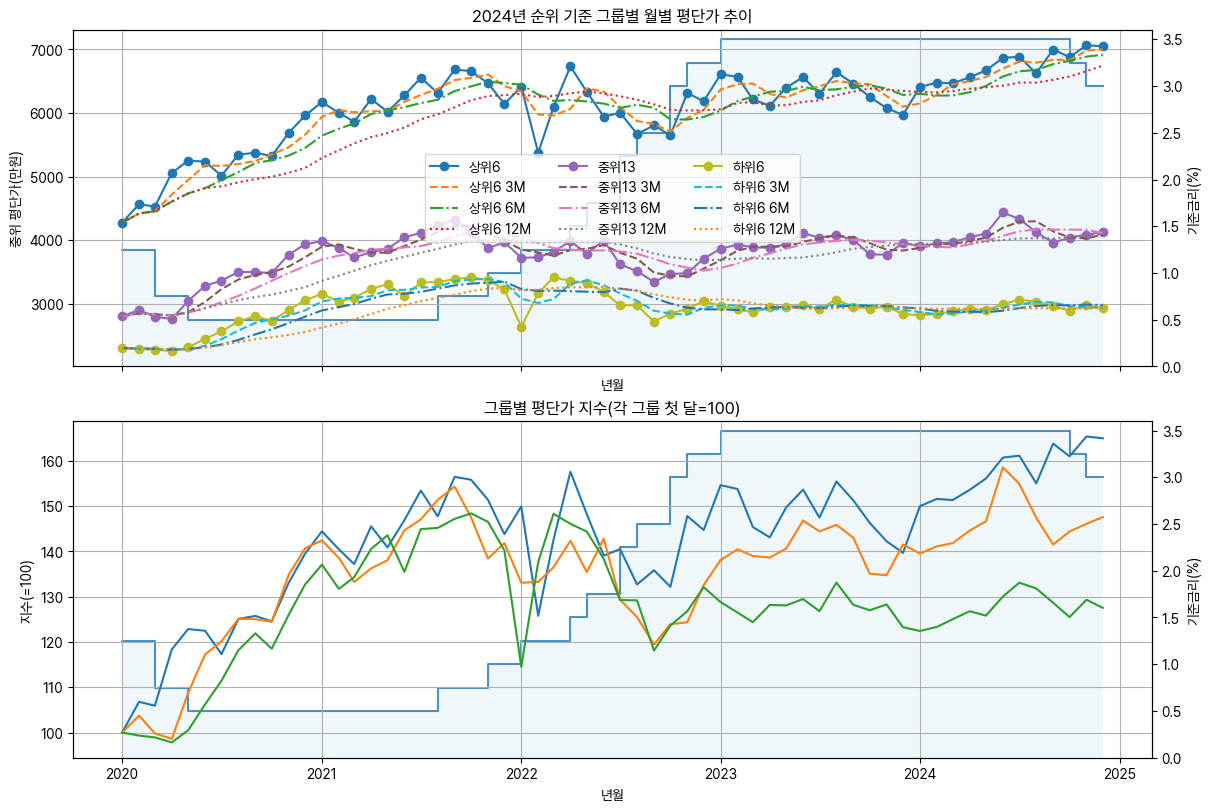

In [80]:
plot_trends_by_2024_rank(df_all, df_2024_c)

### 금리 변동에 따른 그룹별(상위6·중위13·하위6) 가격 추이 해석

#### 개요
- 관찰 구간: 2020–2024
- 금리 계단형(변경월 즉시 반영)과 **그룹별 월별 평단가(수준·지수)**를 동시 비교.
- 결론 요약: **금리 민감도 = 상위6 > 중위13 > 하위6**, 인상기 격차 축소 → 동결·인하기 격차 재확대.

---

#### 1) 2020~2021 후반(초저금리 → 초기 인상)
**상위6**
- 급등, 기울기 최대. 격차 확대의 주도층.
- 금리 저점 구간에서 유동성 수혜가 집중.

**중위13**
- 완만한 상승, 변동성 중간.
- 6M·12M 추세가 매끈해 방어력이 양호.

**하위6**
- 점진 상승, 탄력 약함.
- 지수 기준 상승폭 최소.

> 인사이트: 유동성 장세에서 핵심 입지(상위6)가 초과 수익. 포지셔닝은 공격적으로 가능하나 변동성 관리 필요.

---

#### 2) 2021 후반~2022(연속 금리 인상 국면)
**상위6**
- 가장 먼저 꺾임, 하락 폭/속도 최대.
- 격차가 일시 축소되며 프리미엄 일부 반환.

**중위13**
- 상승 둔화 → 횡보 → 완만 하락.
- 완충 역할, 드로우다운 제한.

**하위6**
- 하락 반응이 지연, 진폭 작음.
- 상대가치 비율(하위/상위)이 0.6 부근까지 접근(상대 강세).

> 인사이트: 긴축 충격이 **고가·레버리지 민감** 구간에 선반영. 방어 전략은 **중위13 분산**이 유리.

---

#### 3) 2023~이후(고금리 정체 → 24년 완만 인하)
**상위6**
- 바닥 확인 후 **회복 선행**, 반등 폭 큼.
- 격차 재확대의 촉매.

**중위13**
- 횡보 후 완만 반등, 변동성 낮음.

**하위6**
- 박스권 지속 후 소폭 상승, 회복 지연.

> 인사이트: 정상화 국면의 **선도 회복**은 상위6에서 발생. 다만 정책·금리 재상승 리스크에 민감.

---

#### 요약 테이블(텍스트)

| 구간 | 상위6 | 중위13 | 하위6 | 격차(상-하) |
|---|---|---|---|---|
| 20~21H2 | 급등·고변동 | 완만상승 | 점진상승 | 확대 |
| 21H2~22 | 선행하락·진폭↑ | 완만하락 | 지연하락·진폭↓ | 일시 축소 |
| 23~이후 | 선행반등·폭↑ | 완만반등 | 지연반등 | 재확대 |

---

#### 투자 시사점
- **상승장/완화 기대**: 상위6 오버웨이트. 추세 동행 시 초과 수익 기대.
- **긴축/불확실**: 중위13 분산으로 하방 리스크 관리.
- **상대가치 룰**: (하위/상위) 비율이 **0.52 하단 접근** 시 하위·중위 비중 확대, **0.60 상단 접근** 시 상위 재확대.

#### 근거
- 대시보드의 그룹별 **수준·지수 곡선**과 **3/6/12M 추세선** 전환 시점.
- 금리 **계단형**(월말 반영)과의 동조/역조 관찰 결과.
